In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from energySystem import System, NaturalGasFurnace, HeatPump, Battery, ThermalStorage
import default_values as DEFAULT

In [3]:
sns.set_context(context="notebook")
plt.rcParams["figure.dpi"] = 300

## Import data

In [4]:
def get_demand_mask_and_price(df, colName, dt):
    col = df[colName].to_numpy() / dt
    mask = col > 0
    price = col[mask][0]
    return mask, price

In [5]:
##### loads
df = pd.read_csv("site1_load.csv")
dt = 1/4 # in hours
powerLoad, heatLoad = df['Power Load [kWh]'].to_numpy(), df['Heat Load [kWh]'].to_numpy()

##### prices
df = pd.read_csv("power_price_B20.csv")
energyPricePower = df["energyPrice"].to_numpy() # $/kWh
# from per kW to per kWh in 15 minutes
powerDemand = [get_demand_mask_and_price(df, colName, dt) for colName in ["peakDemandSummerPrice",
                                                                          "partialPeakDemandSummerPrice",
                                                                          "demandSummerPrice",
                                                                          "peakDemandWinterPrice",
                                                                          "demandWinterPrice"]]
df = pd.read_csv("gas_price.csv")
energyPriceGas = df["energyPrice"].to_numpy() # $/kWh

##### emissions
df = pd.read_csv("power_grid_emissions.csv")
df.ffill(inplace=True)
emissionsPower = df["MOER version 2.0"].to_numpy() # kCO2eq/KWhe
df = pd.read_csv("gas_emissions.csv")
emissionsGas = df["gasEmissions"].to_numpy() # kCO2eq/kWhgas

##### time index
timeIndex = pd.date_range(start='1/1/2023', periods=len(powerLoad), freq='15min')

# clear memory
del df

In [6]:
# number of timesteps
n_timesteps = len(powerLoad)

## Natural Gas Only

In [7]:
system1 = System(
    "baseline",
    timeIndex=timeIndex,
    powerLoad=powerLoad,
    heatLoad=heatLoad,
    powerPrice=energyPricePower,
    gasPrice=energyPriceGas,
    powerMarginalEmissions=emissionsPower,
    gasMarginalEmissions=emissionsGas
)
ngf1 = NaturalGasFurnace(
    n_timesteps=n_timesteps,
    dt=1/4,
    eff=DEFAULT.FURNACE_EFF,
    capacityPrice=DEFAULT.FURNACE_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.FURNACE_LIFETIME)
system1.addComponent(ngf1)
system1.solve(objective="cost", solver="MOSEK")
system1.describe(detailed=True)


System: baseline
1 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 8734.0 kW
Status: optimal

Annual power consumption: 10000.0 MWh
Annual gas consumption: 34521.0 kWh
Annual cost: 3.301 M$
Annual emissions: 11.65 MtonCO2
LCOE (Electricity): 0.169 $/kWh
LCOH (Heat): 0.055 $/kWh
Carbon Intensity of Electricity: 0.367 kgCO2/kWhe
Carbon Intensity of Heat: 0.272 kgCO2/kWhth

Runs from 2023-01-01 00:00:00 to 2023-12-31 23:45:00
Annual power load: 10000.0 MWh
Annual heat load: 29343.0 MWh
Average supply power price: 0.153 $/kWh
Average supply gas price: 0.046 $/kWh
Average supply power emissions: 0.366 kgCO2/kWhe
Average supply gas emissions: 0.231 kgCO2/kWhth
Annualized capex: 0.14 M$
Power opex: 1.545 M$
Gas opex: 1.615 M$
Total power emissions: 3.67 MtonCO2
Total gas emissions: 7.97 MtonCO2


A sanity check: max capa of the gas furnace should be max(heatLoad)/dt

In [8]:
print(f"The difference is {heatLoad.max()/dt - ngf1._variables[1].value} kW.")

The difference is 0.0 kW.


In [9]:
baselineEmissions = system1.totalEmissions.value

## Natural Gas and Heat Pump

In [10]:
hp1 = HeatPump(
    n_timesteps=n_timesteps,
    dt=1/4,
    COP=DEFAULT.HP_COP,
    capacityPrice=DEFAULT.HP_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.HP_LIFETIME
)
system1.addComponent(hp1)
system1.solve(objective="cost", emissionsCap=0.8*baselineEmissions, solver="MOSEK")
system1.describe(detailed=True)

System: baseline
2 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 6264.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 2470.0 kW
Status: optimal

Annual power consumption: 15011.0 MWh
Annual gas consumption: 16836.0 kWh
Annual cost: 3.387 M$
Annual emissions: 9.32 MtonCO2
LCOE (Electricity): 0.173 $/kWh
LCOH (Heat): 0.057 $/kWh
Carbon Intensity of Electricity: 0.362 kgCO2/kWhe
Carbon Intensity of Heat: 0.194 kgCO2/kWhth

Runs from 2023-01-01 00:00:00 to 2023-12-31 23:45:00
Annual power load: 10000.0 MWh
Annual heat load: 29343.0 MWh
Average supply power price: 0.153 $/kWh
Average supply gas price: 0.046 $/kWh
Average supply power emissions: 0.366 kgCO2/kWhe
Average supply gas emissions: 0.231 kgCO2/kWhth
Annualized capex: 0.339 M$
Power opex: 2.254 M$
Gas opex: 0.795 M$
Total power emissions: 5.43 MtonCO2
Total gas emissions: 3.89 MtonCO2


## Natural Gas and Heat Pump and Battery

In [11]:
lion1 = Battery(
    n_timesteps=n_timesteps,
    dt=1/4,
    maxChargeRate=DEFAULT.LION_MAX_CHARGE_RATE,
    capacityPrice=DEFAULT.LION_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.LION_LIFETIME,
    name="Lithium Ion Battery"
)
system1.addComponent(lion1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe(detailed=True)

System: baseline
3 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 5669.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 3066.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    Optimal energy capacity: 2883.0 kWh
    Optimal power capacity: 721.0 kW
Status: optimal

Annual power consumption: 16203.0 MWh
Annual gas consumption: 12629.0 kWh
Annual cost: 3.457 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.176 $/kWh
LCOH (Heat): 0.058 $/kWh
Carbon Intensity of Electricity: 0.323 kgCO2/kWhe
Carbon Intensity of Heat: 0.168 kgCO2/kWhth

Runs from 2023-01-01 00:00:00 to 2023-12-31 23:45:00
Annual power load: 10000.0 MWh
Annual heat load: 29343.0 MWh
Average supply power price: 0.153 $/kWh
Average supply gas price: 0.046 $/kWh
Average supply power emissions: 0.366 kgCO2/

## Natural Gas and Heat Pump and Battery and Thermal Energy Storage

In [12]:
tes1 = ThermalStorage(
    n_timesteps=n_timesteps,
    dt=1/4,
    maxChargeRate=DEFAULT.TES_MAX_CHARGE_RATE,
    lossRate=DEFAULT.TES_LOSS_RATE,
    capacityPrice=DEFAULT.TES_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.TES_LIFETIME
)
system1.addComponent(tes1)
system1.solve(objective="cost", emissionsCap=0.7*baselineEmissions, solver="MOSEK")
system1.describe(detailed=True)

System: baseline
4 component(s)
Component: NaturalGasFurnace
    capacityPrice: 200
    eff: 0.85
    Optimal capacity: 3622.0 kW
Component: HeatPump
    capacityPrice: 1000
    COP: 3
    Optimal capacity: 3306.0 kW
Component: Lithium Ion Battery
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 396.75
    Optimal energy capacity: 1291.0 kWh
    Optimal power capacity: 323.0 kW
Component: ThermalStorage
    socMin: 0
    socMax: 1
    socInitial: 0.5
    socFinal: 0.5
    maxDischargeRate: 0.25
    maxChargeRate: 0.25
    capacityPrice: 25.0
    lossRate: 0
    Optimal energy capacity: 14117.0 kWh
    Optimal power capacity: 3529.0 kW
Status: optimal

Annual power consumption: 16752.0 MWh
Annual gas consumption: 10691.0 kWh
Annual cost: 3.419 M$
Annual emissions: 8.15 MtonCO2
LCOE (Electricity): 0.174 $/kWh
LCOH (Heat): 0.057 $/kWh
Carbon Intensity of Electricity: 0.339 kgCO2/kWhe
Carbon Intensity of

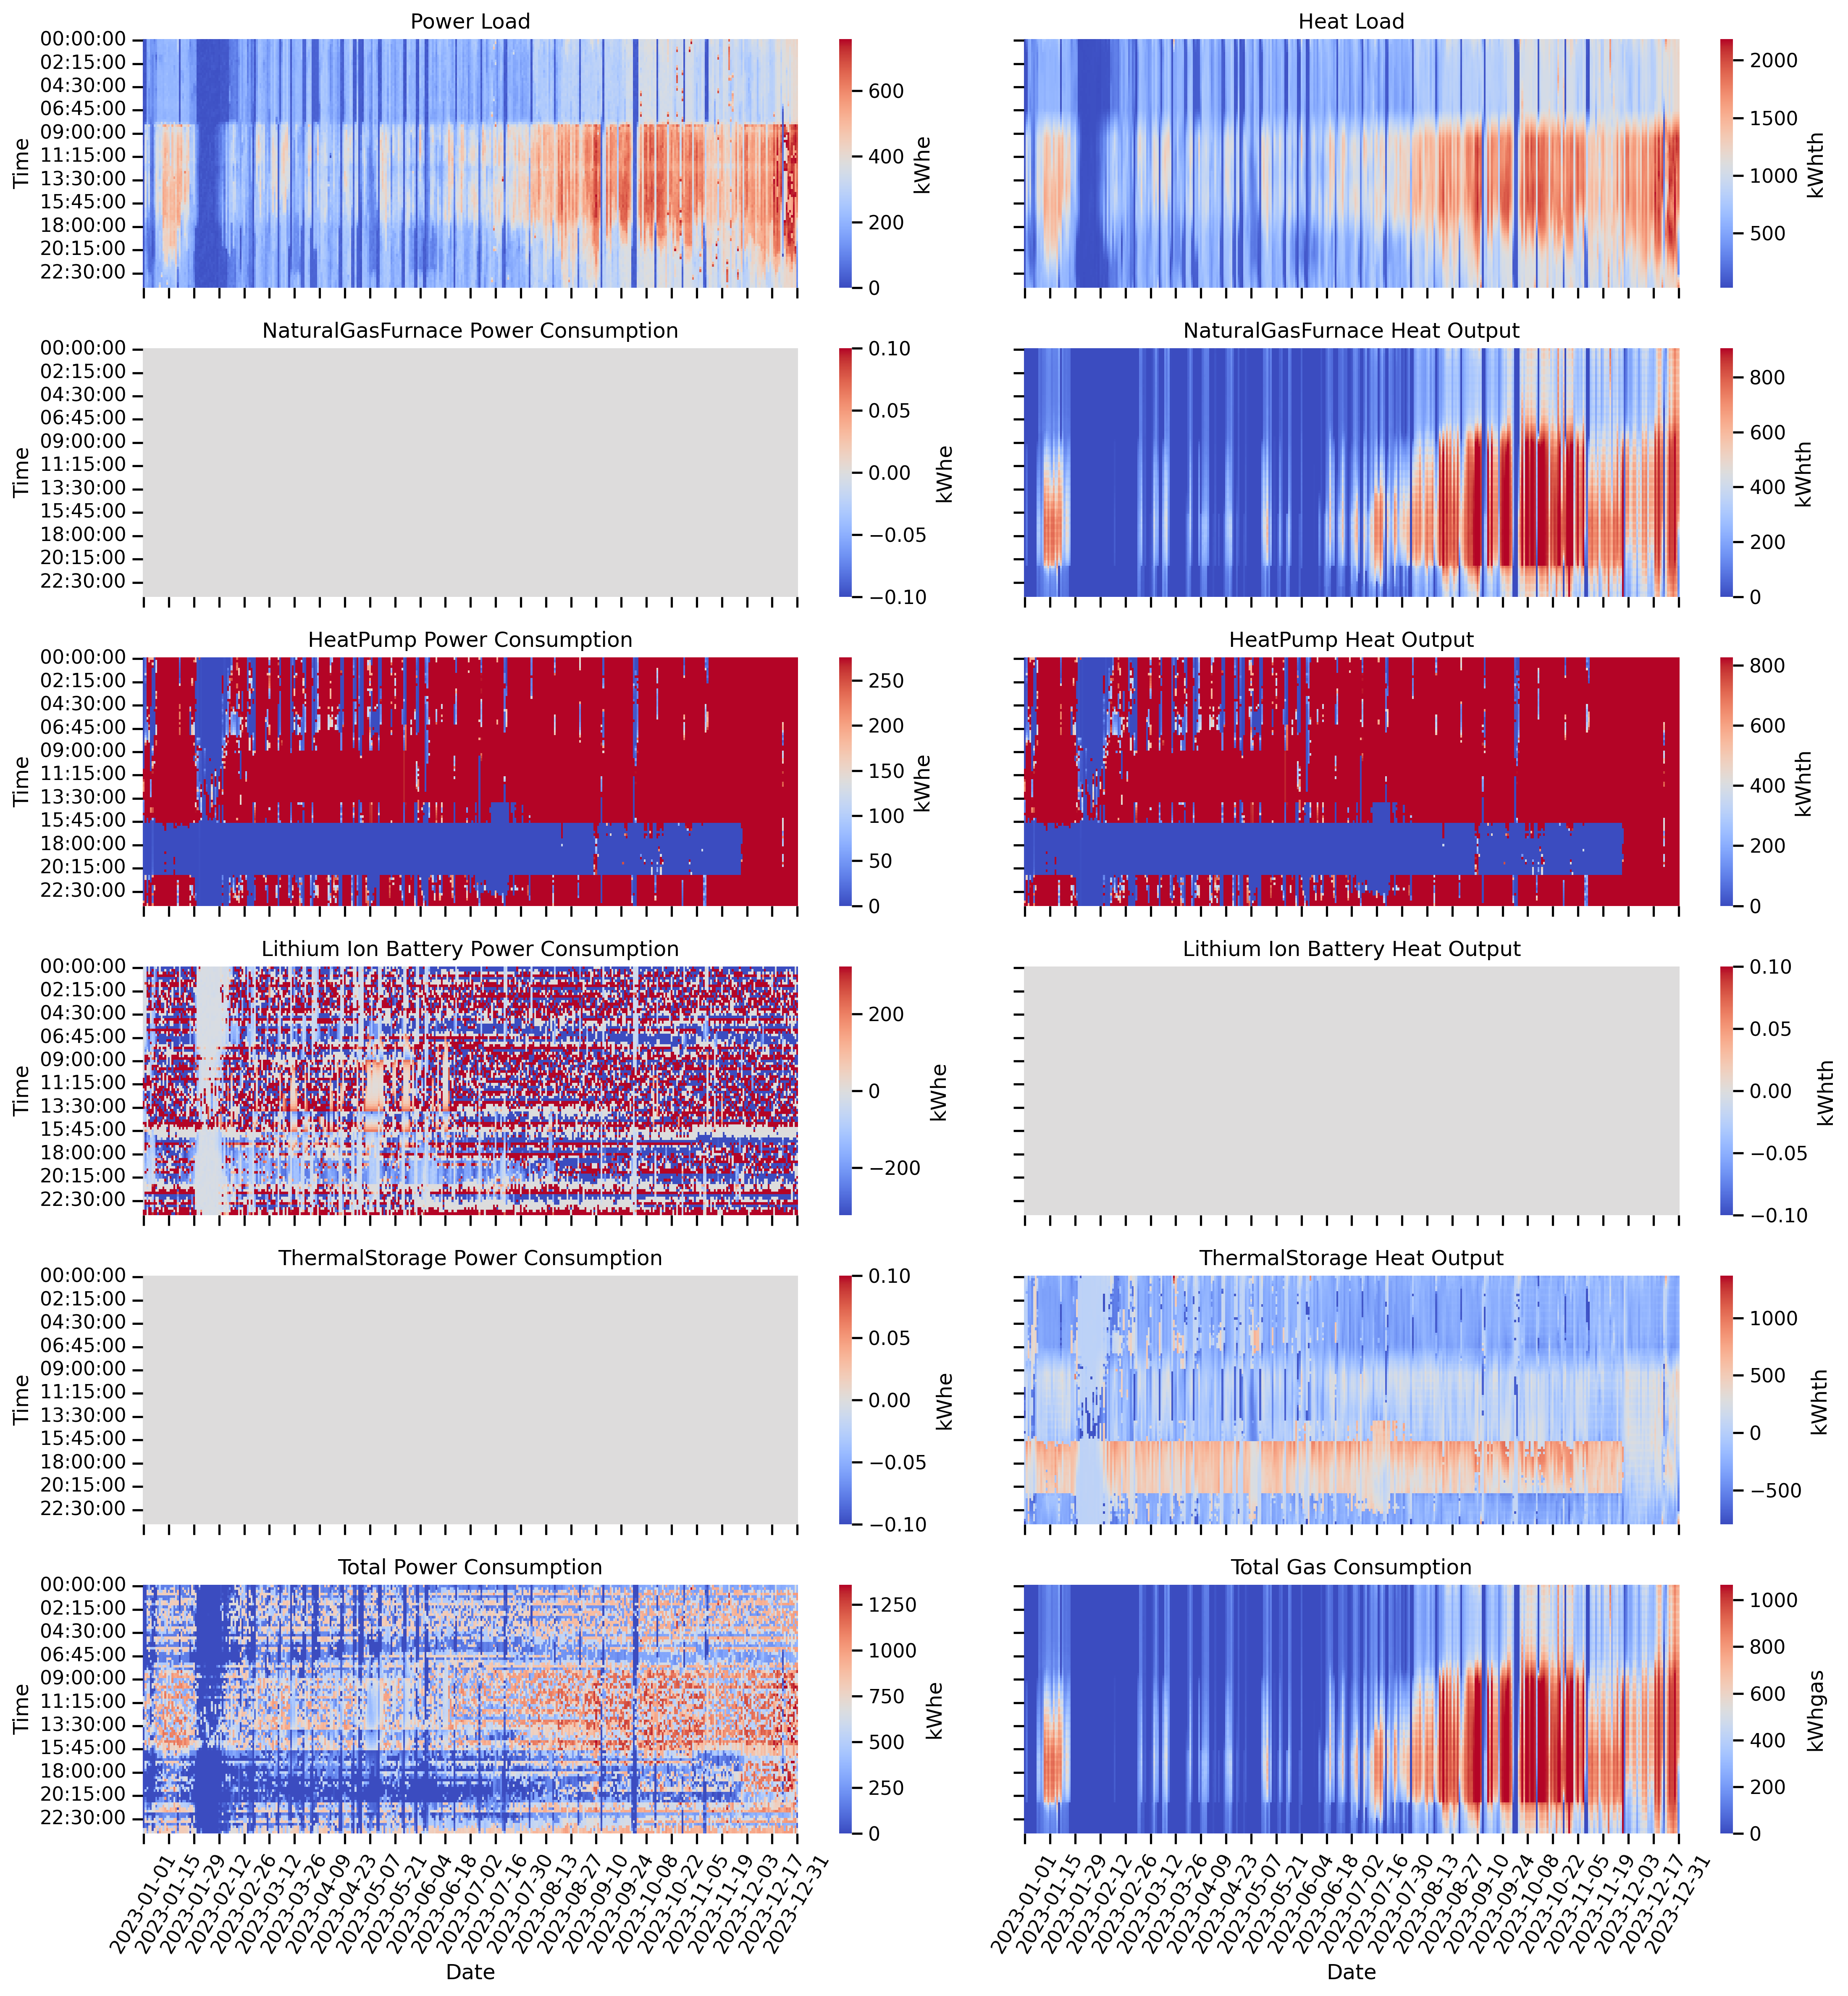

In [13]:
system1.plotHeatmaps();

In [14]:
colors = {'HeatPump': 'C0', 'Power Load': 'C1', 'Lithium Ion Battery': 'C4', 'Total Power Consumption': 'black',
          'NaturalGasFurnace' : 'C5', 'Heat Load': 'C3', 'ThermalStorage': 'C4', 'Total Heat Consumption': 'black',
          'Marginal Power Price': 'C3', 'Marginal Power Emissions': 'C5'}

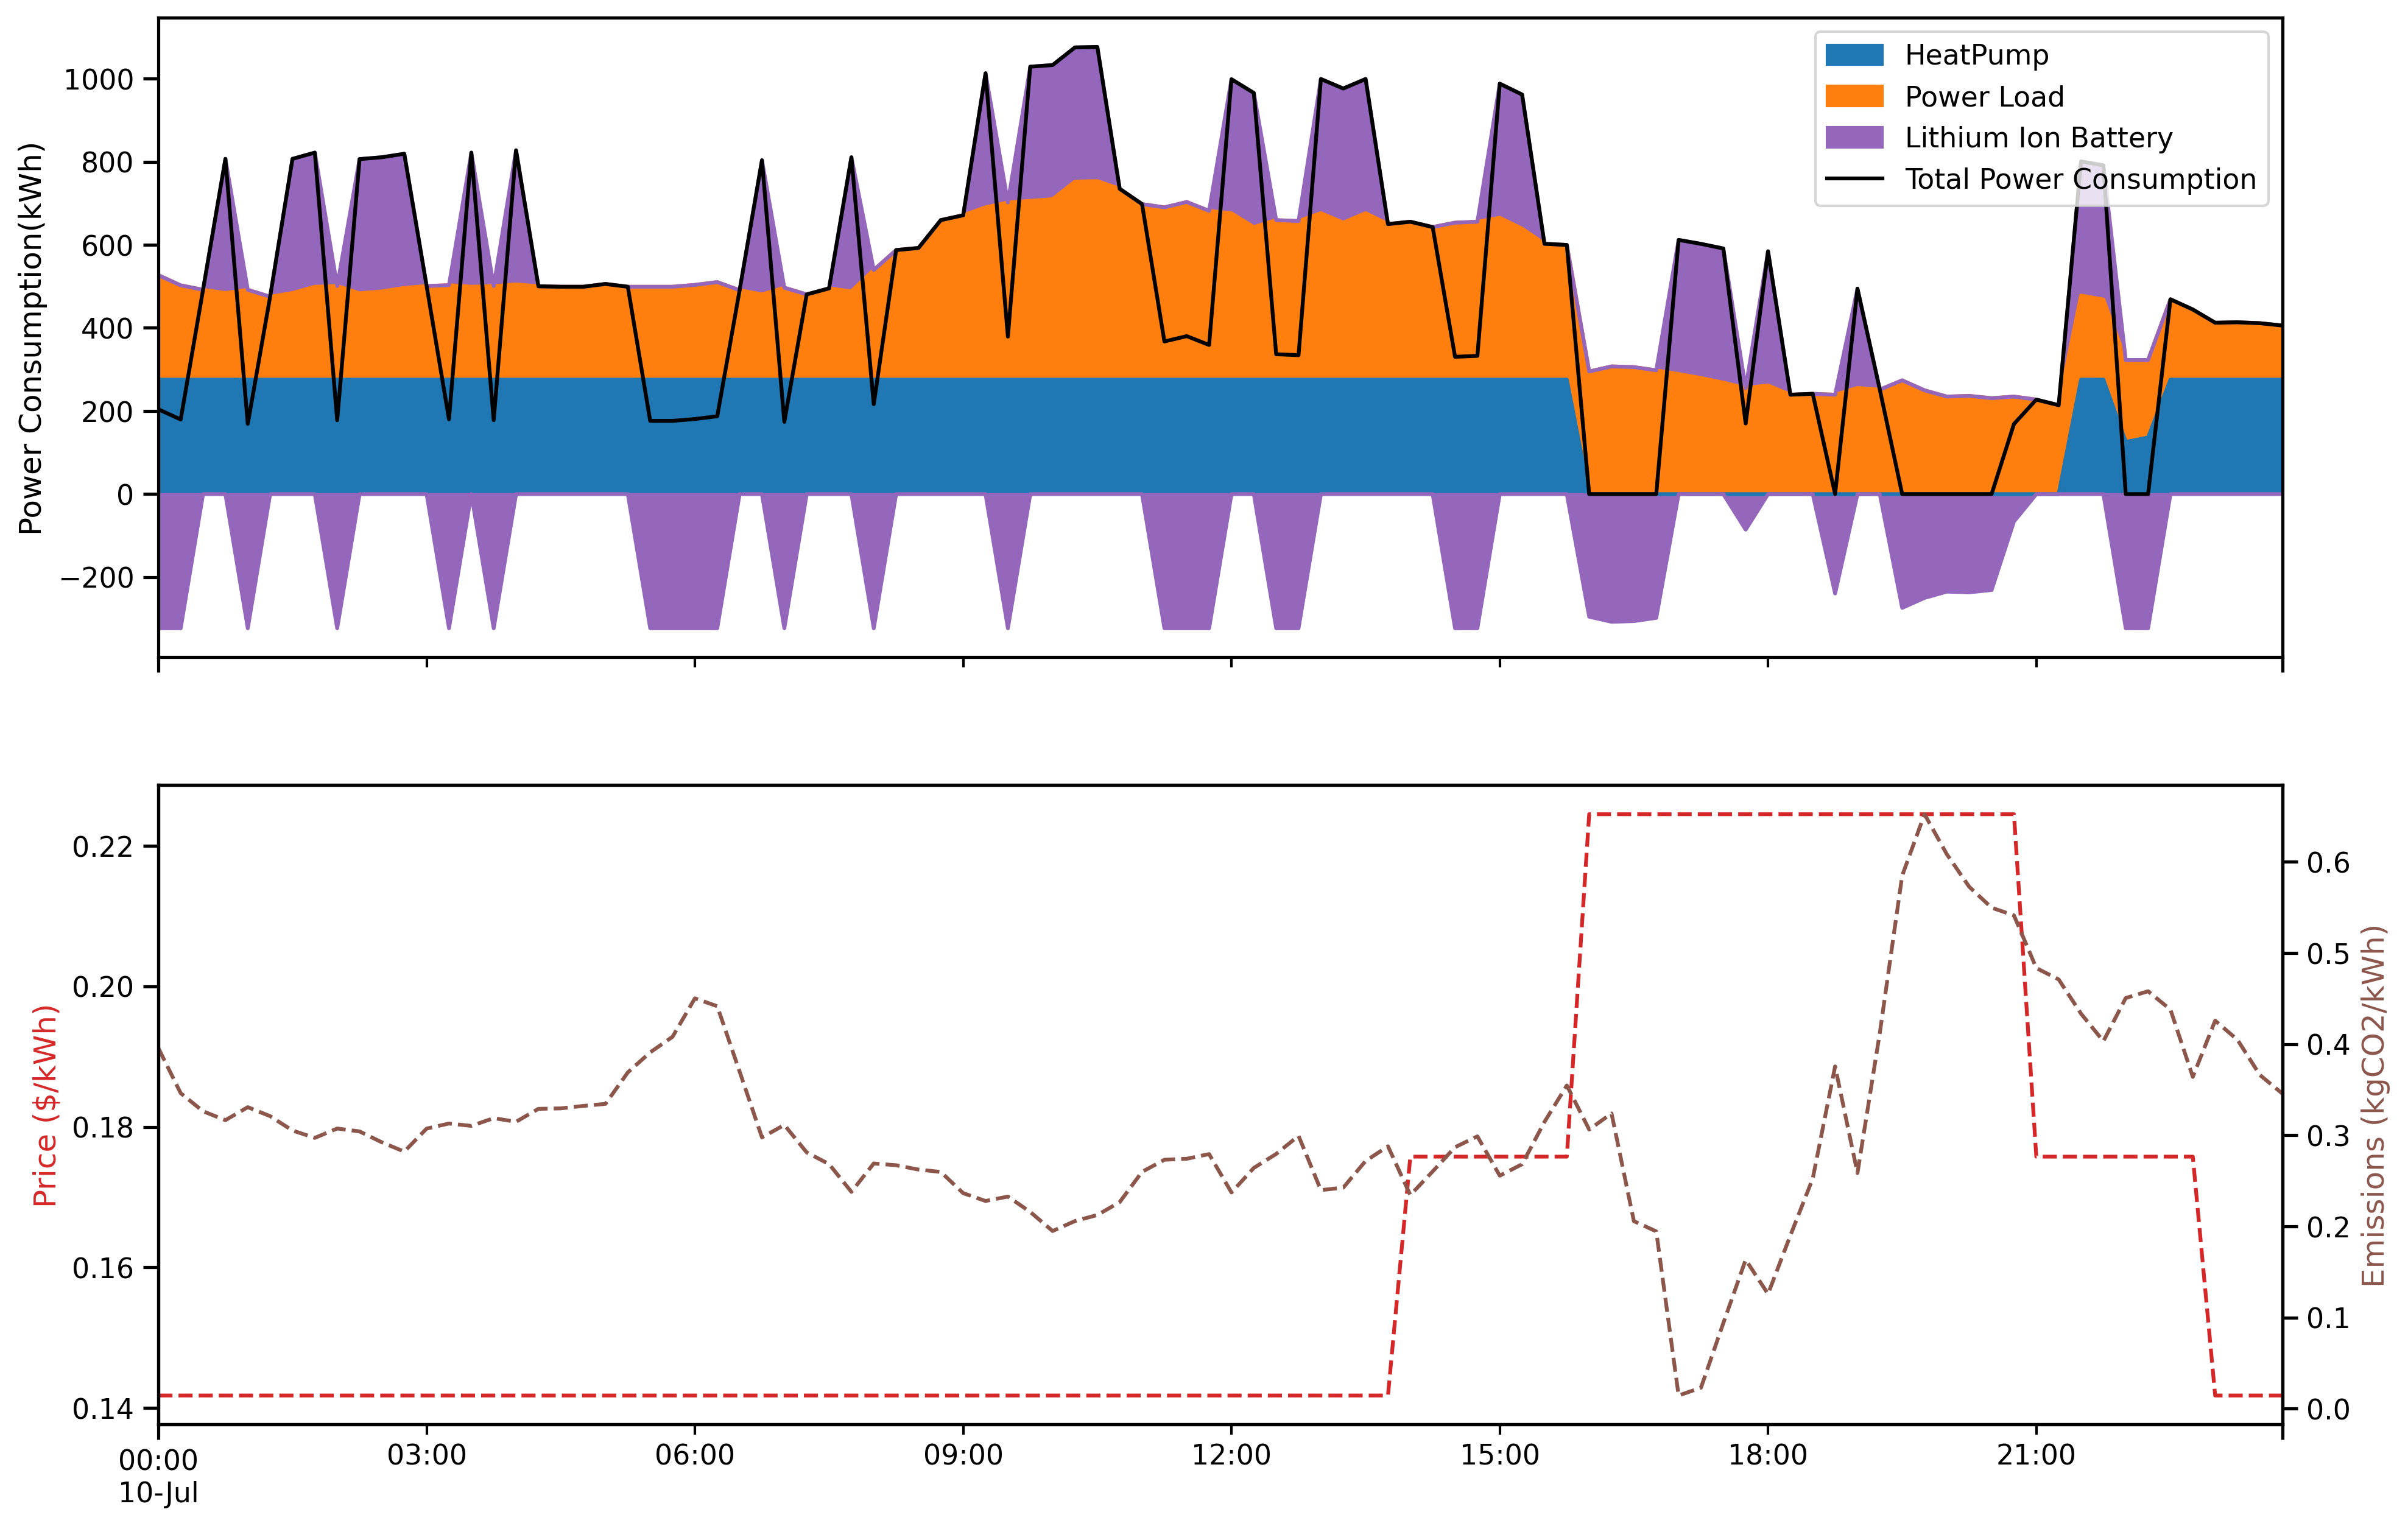

In [15]:
powerConsumers = ['HeatPump', 'Power Load']
powerStorage = ['Lithium Ion Battery']
system1.plot_power(colors, powerConsumers, powerStorage, '2023-07-10');

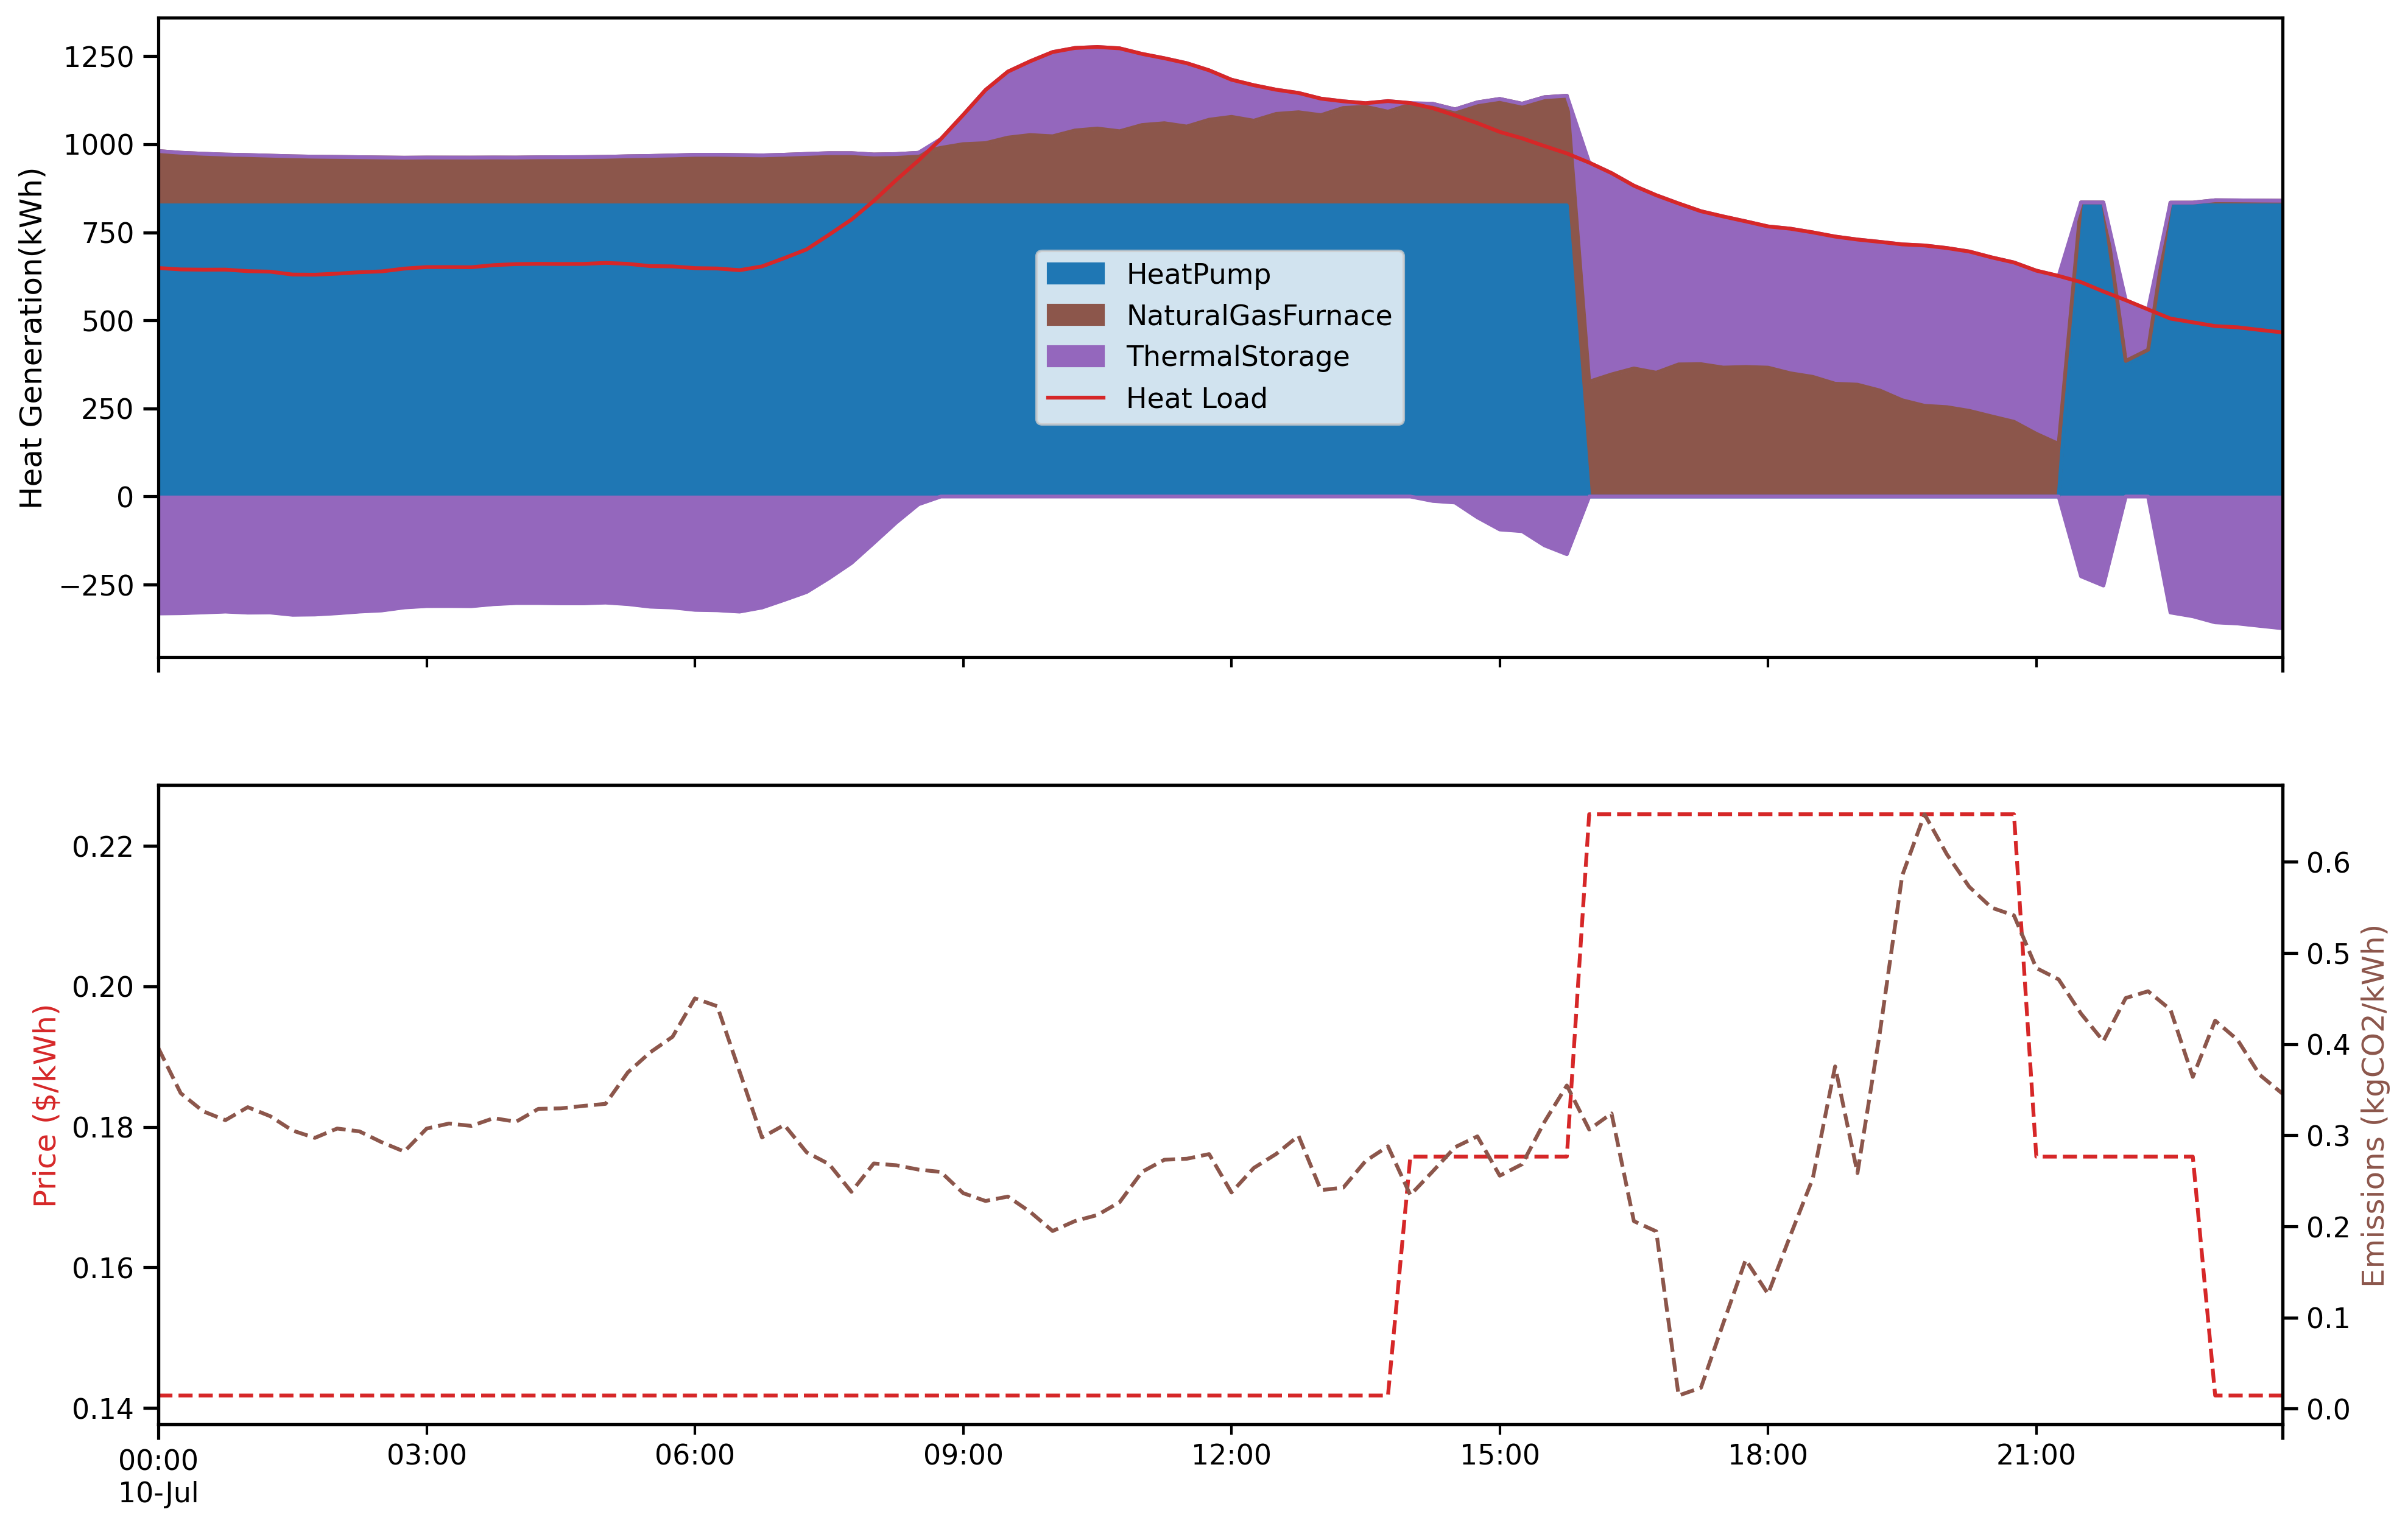

In [16]:
heatGenerators = ['HeatPump', 'NaturalGasFurnace']
heatStorage = ['ThermalStorage']
test = system1.plot_heat(colors, heatGenerators, heatStorage, '2023-07-10')